<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [878]:
%%capture
pip install pyswarms

In [879]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [880]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'
DIAS_OBSERVADOS = 600

In [881]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [882]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [883]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [884]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [885]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [886]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [887]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [888]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [889]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [890]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/Cenarios/cenario01.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


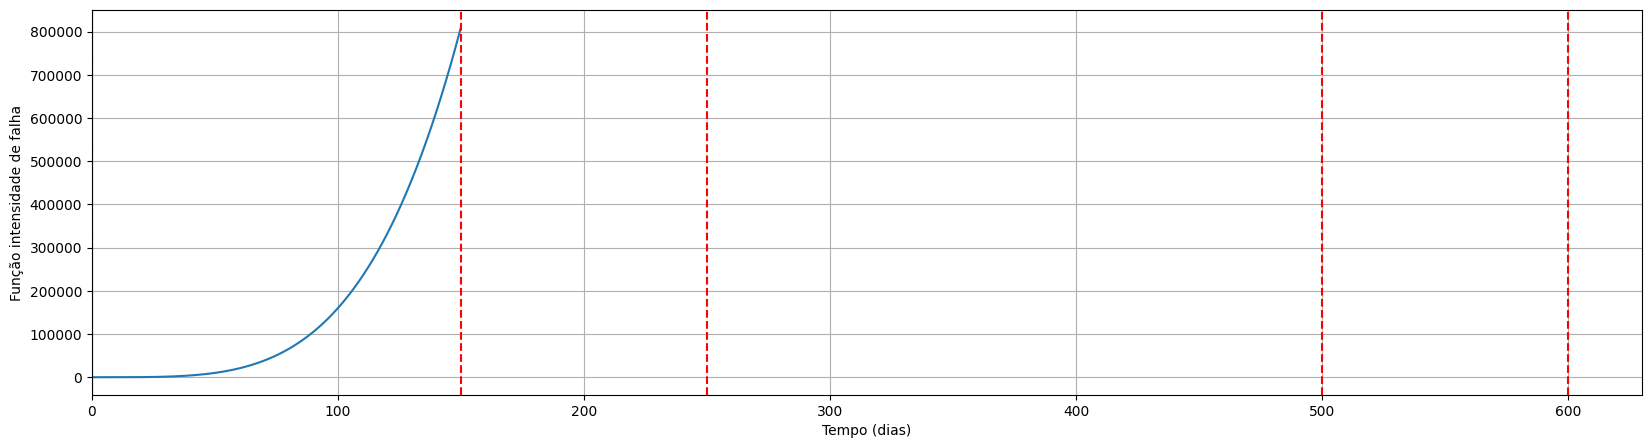

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [891]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [892]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [893]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 20:18:45,049 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=8.87e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 39, 253, 293, 402, 438, 473, 512, 587, 618]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 255586183.60775813, 315058120.62582785, 366269751.4405991, 374453113.43850714, 432567337.23256785, 521838652.6859293, 593279989.3924382, 1541661267.9228563, 1475974984.4857996]
Custo =  170092108650.57782


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 6, 48, 82, 223, 302, 444, 474, 539, 671]
Severidade para cada subsistema: [0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=8.87e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 9, 105, 194, 299, 318, 380, 427, 488, 542, 582, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 18.895680000000002, 3538773.112058463, 29758270.98532023, 83773797.49916467, 124307273.37774454, 137026467.97858876, 192714644.5353987, 893398769.3263987, 1055963993.4809372, 1206700140.8331974, 2025677883.1691015, 2000330770.5308292]
Custo =  124880674455.50175


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 99, 122, 198, 298, 383, 396, 428, 486, 646, 685, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0

pyswarms.single.global_best:  40%|████      |40/100, best_cost=8.87e+10

Custo =  241090279697.74512


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 87, 108, 190, 313, 382, 432, 488, 544, 598]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 1314829.493268646, 1882936.8852184156, 23842392.575606834, 108771562.90224135, 401688265.19770133, 464496046.97694683, 1110233736.6120732, 1282480035.8347, 1518911635.6479182, 1526544248.4653606]
Custo =  117221050046.02734


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 87, 111, 187, 322, 381, 431, 488, 547, 570, 647, 719]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisema

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=7.34e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 88, 105, 139, 192, 383, 428, 485, 543, 585, 636, 677]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 51.53632, 1368342.9989866042, 1782095.9323586312, 4293314.382525391, 8100104.124575956, 231798848.20231214, 540021475.7724922, 1180588772.8720322, 1359093773.3347514, 1521587246.7182717, 1801687588.390883, 1848786116.3147397, 1824328952.918335]
Custo =  133406037944.6258


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 11, 87, 103, 120, 193, 385, 428, 486, 540, 641, 695]
Severidade para cada subsistema: [0.25, 0.2

pyswarms.single.global_best:  68%|██████▊   |68/100, best_cost=7.14e+10

Custo =  249873607764.65137


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 31, 89, 103, 129, 199, 299, 308, 376, 398, 428, 490]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 5249.222399606286, 859613.8641506934, 918966.323737614, 2349041.5542425984, 9425776.337876262, 29462838.976807535, 46663559.20974295, 61461858.54161323, 79152204.86732316, 288020049.4496571, 419927205.1971575, 1018336357.2650583]
Custo =  71353964412.5081


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 33, 89, 103, 148, 198, 299, 310, 374, 402, 429, 490, 692]
Severidade para cad

pyswarms.single.global_best:  82%|████████▏ |82/100, best_cost=7.08e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 103, 198, 299, 309, 377, 396, 427, 487, 573, 652]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1857788.6675641907, 15095657.87400343, 65243770.881223135, 84567339.01818106, 99482785.77220137, 114264067.27666207, 327810306.1712975, 451478118.9237894, 811852228.2024517, 1332707908.756977, 1153527223.10801]
Custo =  107086791814.96388


Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 10, 35, 102, 123, 199, 308, 382, 391, 427, 487, 572, 643, 670, 702]
Severidade para cada subsistema: [0.25,

pyswarms.single.global_best:  96%|█████████▌|96/100, best_cost=7.08e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 30, 101, 200, 294, 309, 385, 393, 428, 489, 637, 678]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 4372.436942997232, 1810387.865099947, 16761494.079716727, 58358601.60705169, 87066018.07930383, 107041284.84532131, 112807766.85775843, 355071398.9786154, 483301303.015881, 1635875505.913883, 1916132860.1050396, 1654595189.5322032]
Custo =  122067500366.16255


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 31, 101, 200, 295, 309, 378, 394, 428, 489, 645, 666, 719]
Severidade para cada subsistema: [0.25, 0.5

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=7.08e+10
2023-09-24 20:18:46,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35370347 3.14839853 2.06470673 3.3346072  0.23792491 0.5967157
 1.7086687  2.35931716 2.4363418  5.85473372 3.35230397 2.88929189
 1.88239222 2.71728224 3.22278141 4.21605367 3.18340751 4.65595734
 2.90467003 0.85034268 4.49585119 1.84178084 6.46129136 6.8572327 ]
2023-09-24 20:18:46,584 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 32, 101, 200, 297, 310, 376, 390, 428, 488, 578, 679]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 6262.1688321841875, 1733731.630428347, 16684837.845045129, 62205107.970187366, 87505713.72349156, 101438681.5202454, 111475420.11463022, 373634103.8735217, 498253476.0396602, 893722311.0558903, 1725734361.102982, 1461044960.768302]
Custo =  113912332400.1476


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 33, 101, 200, 298, 310, 371, 428, 487, 579, 660]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.2

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,648 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35375417 3.1483994  2.06470363 3.33459252 0.23792424 0.59671579
 1.70864035 2.35930155 2.43634157 5.85474462 3.352448   2.88929083
 1.88238527 2.71728385 3.22280833 4.2161224  3.18340723 4.65595832
 2.90467658 0.85034006 4.49585122 1.7120752  6.46121334 6.85739137]
2023-09-24 20:18:46,649 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 101, 145, 200, 296, 309, 373, 427, 487, 581, 649]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1660352.1061797822, 2764235.5156635875, 7402915.676220094, 51584438.89350856, 76558157.33441819, 89350230.14071077, 155592469.13071954, 839606289.5288714, 1267189229.2548876, 1692482298.3948812, 1522948603.3945823]
Custo =  118421902286.22826


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,680 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35376923 3.14839919 2.06470982 3.33460024 0.23792405 0.59671565
 1.70856225 2.3593059  2.43634142 5.85499811 3.35243763 2.88929421
 1.88239529 2.7172822  3.22280817 4.21607001 3.18340761 4.65595856
 2.90467442 0.85038407 4.49585117 1.65554308 6.46119194 6.85728626]
2023-09-24 20:18:46,682 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 101, 135, 201, 296, 309, 380, 426, 487]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1660352.1061797822, 2221407.670625023, 8748962.222377893, 25808750.457935825, 50782468.89884546, 67461840.74507418, 121222832.06475052, 816116723.524722, 1438188420.161634]
Custo =  82165816477.69386


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,713 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35376601 3.14839894 2.06471537 3.33460814 0.23792404 0.59671553
 1.70849789 2.35931187 2.43634133 5.85514807 3.35239181 2.88929701
 1.88240417 2.71728072 3.22280083 4.21602173 3.18340794 4.65595843
 2.90467216 0.85041696 4.49585113 1.60782733 6.4611968  6.85718977]
2023-09-24 20:18:46,717 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 101, 201, 295, 309, 386, 426, 487, 599, 695]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1660352.1061797822, 17169471.152080256, 59215362.79598738, 86059116.17477147, 106750447.10569002, 152177648.24493062, 847071539.704902, 1457565760.9351146, 2305339532.95092, -765935542.4699807]
Custo =  247807790873.85345


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35375385 3.14839868 2.06471948 3.33461521 0.2379241  0.59671546
 1.70844762 2.3593174  2.43634134 5.85526225 3.35234564 2.88929919
 1.88241105 2.71727974 3.22279011 4.21598146 3.18340822 4.65595818
 2.90466978 0.85043261 4.4958511  1.60675069 6.46121807 6.85711489]
2023-09-24 20:18:46,735 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 126, 201, 294, 310, 425, 488, 576, 689, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1858876.3056195811, 10212089.749211045, 26082368.02166482, 57047765.29550111, 124344008.9884794, 256937111.77343178, 635767912.7877301, 1657542108.2262683, 3156718184.717741, -741021260.7553906]
Custo =  429663046271.6473


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,749 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35374199 3.14839841 2.06472169 3.33461987 0.23792429 0.59671544
 1.70842463 2.35932237 2.43634143 5.85535964 3.35230196 2.88929939
 1.88241475 2.71727954 3.22277988 4.21595624 3.18340841 4.65595781
 2.90466765 0.85042775 4.49585109 1.6718715  6.46125442 6.85705777]
2023-09-24 20:18:46,750 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 130, 201, 294, 310, 425, 487, 637, 686, 700]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1971851.678983972, 9471928.161197895, 50260042.72143282, 81225439.99526912, 148521683.6882474, 277444492.1055672, 1454804352.3081686, 1813029564.7860646, 1914543988.5932794, -1347523144.304276]
Custo =  240852302485.29263


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.3537244  3.14839817 2.06471977 3.33462313 0.23792453 0.59671549
 1.70843494 2.3593259  2.43634154 5.85528268 3.35226307 2.8892977
 1.88241305 2.71728003 3.22277096 4.21594041 3.18340845 4.65595738
 2.90466579 0.85041331 4.49585111 1.76920504 6.46129569 6.85702612]
2023-09-24 20:18:46,768 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 35, 99, 201, 294, 310, 425, 487, 687, 696]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 10276.292139331119, 1447947.2922478737, 17688366.49024664, 58476481.050481565, 89441878.32431786, 156738122.01729614, 285660930.43461597, 2734132082.4467497, 2797218542.3544703, -311927670.38075733]
Custo =  227438011450.7153


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=7.08e+10
2023-09-24 20:18:46,782 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 70761659393.00742, best pos: [1.35370362 3.14839802 2.0647142  3.33462535 0.23792486 0.59671557
 1.70845478 2.35932651 2.43634169 5.85507685 3.35223979 2.88929499
 1.8824063  2.71728075 3.22276394 4.21595566 3.18340831 4.65595699
 2.90466459 0.85038926 4.49585114 1.86119327 6.46133267 6.85703689]
2023-09-24 20:18:46,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 35, 99, 140, 201, 294, 310, 330, 425, 486, 678, 713]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 32.0, 10276.292139331119, 1447947.2922478737, 2317499.1912302417, 7968840.668434646, 23839118.94088842, 54804516.21472471, 56101883.06712764, 199521994.0834765, 324841133.0581758, 2509160622.711791, 2795872960.484559, -979654034.776773]
Custo =  235407481018.18323


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,794 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368488 3.14839803 2.06470757 3.33462678 0.23792517 0.59671568
 1.70848768 2.35932683 2.43634183 5.85478974 3.35222881 2.88929239
 1.8823979  2.7172816  3.22276261 4.21599599 3.18340794 4.65595672
 2.90466508 0.85035768 4.49585116 1.9395055  6.46135632 6.8570929 ]
2023-09-24 20:18:46,796 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 35, 99, 201, 294, 310, 331, 425, 485, 630]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 10276.292139331119, 1447947.2922478737, 17688366.49024664, 58476481.050481565, 89441878.32431786, 90842698.02218053, 231929156.42583507, 353710339.682926, 1428235599.6715622, 1321248417.4436607]
Custo =  68520344337.58187


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,811 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35366801 3.14839805 2.06470159 3.33462807 0.23792544 0.59671577
 1.7085173  2.35932711 2.43634195 5.85453133 3.35221894 2.88929005
 1.88239034 2.71728236 3.2227614  4.21603229 3.18340761 4.65595649
 2.90466553 0.85032925 4.49585119 2.0099865  6.46137761 6.85714332]
2023-09-24 20:18:46,813 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 98, 201, 295, 311, 332, 387, 425, 484]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1396134.3858704045, 18012267.56093291, 60058159.204840034, 91427991.38506871, 92844303.87525247, 139953711.05790272, 182325959.53020948, 838833956.0394611, 1485097329.6867785]
Custo =  85315220969.92503


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,830 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35365717 3.14839806 2.06469768 3.33462892 0.23792568 0.59671585
 1.70854378 2.35932732 2.43634204 5.85434907 3.3522111  2.88928797
 1.88238453 2.71728288 3.22276048 4.21605506 3.18340734 4.65595628
 2.9046658  0.85031168 4.49585121 2.07086443 6.46139525 6.8571824 ]
2023-09-24 20:18:46,831 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 98, 201, 295, 311, 332, 383, 426, 484]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1396134.3858704045, 18012267.56093291, 60058159.204840034, 91427991.38506871, 92844303.87525247, 133930963.14828277, 183464389.63247275, 829343771.9163331, 1475607145.5636504]
Custo =  85293478221.89337


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35365519 3.14839806 2.06469649 3.33462963 0.23792584 0.59671588
 1.70855517 2.35932747 2.43634209 5.85422824 3.35220586 2.88928656
 1.88238276 2.71728317 3.22275981 4.21607527 3.18340717 4.6559561
 2.904666   0.85030384 4.49585122 2.10640907 6.46140277 6.85720326]
2023-09-24 20:18:46,855 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 98, 201, 295, 310, 332, 380, 426, 484, 634, 673]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1396134.3858704045, 18012267.56093291, 60058159.204840034, 89141613.77505815, 90650578.7498791, 127571030.93081203, 181332022.25048837, 827211404.5343487, 1985778585.754543, 2243406700.5833745, 1997623371.8212543]
Custo =  133633677983.14865


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,868 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35365346 3.14839806 2.06469865 3.33462986 0.23792587 0.59671586
 1.70854765 2.35932758 2.43634205 5.85417695 3.35220291 2.88928537
 1.88238223 2.71728305 3.22275957 4.21607079 3.1834072  4.65595608
 2.90466591 0.85031087 4.49585122 2.13227073 6.46140065 6.85720793]
2023-09-24 20:18:46,869 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 296, 310, 331, 379, 427, 484, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 61054546.33778447, 88249797.57320356, 89650617.27106623, 126210204.16925804, 183361682.07788408, 818603215.2193025, 4471160901.291302, 4087692729.8098655]
Custo =  139176159286.34055


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,883 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35365424 3.14839805 2.06470241 3.33462956 0.23792572 0.59671578
 1.70853585 2.35932753 2.43634199 5.85420631 3.35220461 2.88928625
 1.88238358 2.71728279 3.22276006 4.21605395 3.18340741 4.65595621
 2.9046656  0.85032559 4.49585121 2.12435095 6.46139375 6.85719721]
2023-09-24 20:18:46,885 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 296, 310, 330, 379, 427, 484, 581, 631]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 61054546.33778447, 88249797.57320356, 89547164.42560649, 127081784.50289297, 184233262.411519, 819474795.5529375, 1265983296.180205, 1531570927.8681426, 626388775.826111]
Custo =  219445484581.33624


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,900 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35365795 3.14839804 2.06470711 3.33462903 0.23792551 0.59671571
 1.70851474 2.35932745 2.43634189 5.85437746 3.35221054 2.88928812
 1.88238856 2.71728224 3.22276096 4.21602167 3.18340772 4.65595638
 2.90466518 0.85034141 4.49585121 2.11203395 6.46138434 6.85718132]
2023-09-24 20:18:46,902 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 296, 310, 382, 427, 484, 571, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 61054546.33778447, 88249797.57320356, 105684957.44146901, 158489247.90726423, 793730781.0486827, 1155082773.398158, 2416340111.019844, 2387221885.4598713]
Custo =  118091267074.14381


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 135, 201, 296, 310, 385, 427, 485, 589]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2156714.7433311814, 8684269.29508405, 153731354.85434195, 180926606.08976105, 200350937.06770578, 248933395.00967515, 900227861.0341299, 1417328599.2576303, 1460269607.1683013]
Custo =  100519294324.16388


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,914 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35366145 3.14839803 2.06471141 3.33462806 0.23792526 0.59671564
 1.7084937  2.35932735 2.4363418  5.85464712 3.35221791 2.88929039
 1.88239416 2.71728155 3.22276215 4.21598697 3.18340804 4.65595656
 2.90466479 0.8503584  4.4958512  2.09804388 6.46137383 6.85716696]
2023-09-24 20:18:46,915 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35366826 3.14839802 2.06471443 3.33462691 0.23792503 0.59671559
 1.70847388 2.35932722 2.43634173 5.85491757 3.35222719 2.88929274
 1.88239999 2.71728095 3.22276326 4.2159584  3.18340831 4.65595673
 2.9046645  0.85



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 134, 201, 295, 310, 388, 427, 486, 582, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2115388.391325647, 8829472.983299904, 50875364.62720703, 79958819.19742514, 101544962.44835502, 146025967.839828, 813577217.834623, 1256477483.3027542, 1828708349.028883, 1807449809.1801515]
Custo =  109095061363.0653


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35367906 3.14839801 2.06471524 3.33462586 0.23792482 0.59671554
 1.70845744 2.35932704 2.43634168 5.85513582 3.35223558 2.88929477
 1.88240493 2.71728041 3.22276413 4.21593932 3.18340849 4.65595689
 2.90466424 0.85038537 4.49585116 2.01190632 6.46135064 6.85709897]
2023-09-24 20:18:46,943 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 122, 201, 295, 310, 427, 486, 596, 666, 695]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1771299.4954311189, 11049407.09380534, 27505874.092141554, 56589328.66235966, 127647938.83321798, 247795008.98953503, 832106008.7694161, 1317941058.300019, 2743980986.336934, 2428626210.9909563]
Custo =  278616404439.3491


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,956 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368952 3.14839801 2.06471477 3.33462513 0.2379247  0.59671553
 1.70845104 2.35932685 2.43634167 5.85523705 3.3522429  2.88929604
 1.88240889 2.71728015 3.22276463 4.21593128 3.18340857 4.65595701
 2.90466401 0.85038912 4.49585115 1.96617696 6.46134098 6.85706862]
2023-09-24 20:18:46,957 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 426, 486, 584, 672]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 157726068.36997175, 280447825.2991992, 741860874.6385859, 1410524537.2740896, 1387190846.567966]
Custo =  71358807834.44707


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:46,975 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369797 3.14839801 2.06471432 3.33462466 0.23792462 0.59671555
 1.70845237 2.35932668 2.43634168 5.85532596 3.3522457  2.88929695
 1.88241149 2.71727999 3.22276457 4.21593434 3.18340857 4.65595709
 2.9046641  0.85038769 4.49585114 1.91714196 6.46133466 6.85704182]
2023-09-24 20:18:46,977 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 426, 487, 680]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 157726068.36997175, 284009850.32690716, 2509400974.1368413, 2241559084.601435]
Custo =  80449146586.96167


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 426, 486, 591, 687]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 157726068.36997175, 280447825.2991992, 811008964.5911691, 1623295407.0820541, 1596620284.8734162]
Custo =  76119066910.26976



2023-09-24 20:18:46,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35370437 3.14839802 2.06471252 3.33462478 0.23792456 0.59671558
 1.70845887 2.35932654 2.4363417  5.85527154 3.35224789 2.88929747
 1.88240983 2.71727995 3.22276428 4.21594527 3.18340849 4.65595707
 2.90466424 0.85038076 4.49585114 1.87328465 6.46133018 6.85701783]
2023-09-24 20:18:46,999 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 389, 425, 486]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 110915959.40420637, 150688424.83006114, 839828173.1144373, 1469904376.2109904]
Custo =  83117409960.74388


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35370564 3.14839802 2.06471073 3.33462514 0.23792454 0.59671563
 1.70847327 2.35932643 2.43634175 5.8551432  3.35224662 2.88929671
 1.8824049  2.71728037 3.22276358 4.2159669  3.18340836 4.65595697
 2.90466459 0.85036942 4.49585114 1.84449042 6.46132681 6.85700001]
2023-09-24 20:18:47,021 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,039 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35370366 3.14839803 2.06470849 3.3346256  0.23792459 0.59671569
 1.70848693 2.35932644 2.4363418  5.8549565  3.35224499 2.88929542
 1.88239857 2.7172809  3.22276268 4.21599466 3.18340813 4.65595684
 2.90466499 0.85



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 133, 201, 295, 310, 387, 425, 485, 595, 681]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2076332.4331853255, 8980865.644768823, 51026757.28867595, 80110211.85889405, 100955898.88942832, 143328147.36173508, 816049333.2268785, 1396875695.2014344, 2079134853.9666686, 2053787741.3283963]
Custo =  114605358296.41403


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35370173 3.14839804 2.0647063  3.33462617 0.23792467 0.59671573
 1.70849933 2.35932652 2.43634185 5.85478303 3.35224061 2.88929358
 1.88239273 2.71728156 3.22276185 4.21601989 3.18340787 4.6559567
 2.90466537 0.85034433 4.49585115 1.8312336  6.46132873 6.85700025]
2023-09-24 20:18:47,060 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 386, 425, 485, 592, 654, 702]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108975126.05243763, 152665937.868464, 825387123.7336074, 1373680979.441638, 1765519593.0704224, 4186273533.0107794, 4156255758.5085726]
Custo =  309345618993.1075


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369692 3.14839804 2.06470448 3.33462668 0.23792487 0.59671577
 1.70850939 2.35932666 2.43634189 5.85462841 3.35223579 2.88929188
 1.88238787 2.71728217 3.22276126 4.21603575 3.18340765 4.65595657
 2.9046657  0.85033635 4.49585116 1.83731102 6.46133577 6.85703435]
2023-09-24 20:18:47,082 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 145, 201, 295, 310, 384, 425, 485, 571, 685, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 2676704.876531921, 7539945.165993575, 149077449.54537806, 178160904.11559618, 196903525.98401898, 243269696.3827022, 915990882.2478456, 1271780801.00378, 2284498389.4288235, 2321433363.122787, -1494671768.610826]
Custo =  255781845103.3177


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 383, 426, 484, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 106929602.40862004, 156463028.89281005, 802342411.1766703, 4191312469.4074097, 3827577810.748244]
Custo =  133623989189.26855


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369173 3.14839805 2.06470367 3.33462716 0.23792505 0.59671577
 1.70851827 2.35932679 2.4363419  5.85449107 3.35222973 2.88929049
 1.88238377 2.71728264 3.2227609  4.21604182 3.18340749 4.65595647
 2.90466599 0.85033453 4.49585117 1.85449603 6.46134718 6.85708238]
2023-09-24 20:18:47,108 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 383, 426, 484, 588, 647]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 106929602.40862004, 156463028.89281005, 802342411.1766703, 1316302246.0127788, 1670905436.1298633, 1507831110.755052]
Custo =  118102749615.7438



2023-09-24 20:18:47,125 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536869  3.14839805 2.06470401 3.33462757 0.23792523 0.59671577
 1.7085231  2.35932691 2.43634191 5.85439225 3.35222424 2.88928956
 1.88238115 2.71728278 3.22276094 4.21603376 3.18340739 4.65595641
 2.90466613 0.85033883 4.49585117 1.89035801 6.46135958 6.85712688]
2023-09-24 20:18:47,127 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 383, 426, 484, 661, 700]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 106929602.40862004, 156463028.89281005, 802342411.1766703, 2550668506.3084702, 2850984723.1229944, -411082409.7745609]
Custo =  261210046289.19104


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,147 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368196 3.14839805 2.06470445 3.33462793 0.23792539 0.59671575
 1.70851694 2.35932702 2.43634189 5.85436249 3.35221938 2.88928946
 1.88237896 2.71728261 3.2227612  4.21602187 3.18340732 4.65595638
 2.90466602 0.85034432 4.49585118 1.92681862 6.46136997 6.85715758]
2023-09-24 20:18:47,149 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 126, 201, 295, 310, 383, 426, 485, 583, 685]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 1787946.6346118948, 10141160.078203358, 26597627.076539576, 55681081.646757685, 73760776.7511242, 123294203.2353142, 785306497.3974127, 1243872884.9053524, 2114525069.4180841, -585695546.4850636]
Custo =  239449025956.04276


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,163 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35367792 3.14839805 2.06470535 3.33462813 0.23792551 0.59671573
 1.70851069 2.3593271  2.43634187 5.85434442 3.35221607 2.88928964
 1.88237918 2.71728233 3.22276155 4.21600854 3.18340743 4.65595641
 2.90466574 0.85035144 4.49585118 1.95970618 6.4613763  6.85716924]
2023-09-24 20:18:47,165 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 121, 201, 295, 310, 384, 427, 485, 598, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 1677388.1800299305, 11198489.141862597, 152735993.5212471, 181819448.0914652, 200562069.959888, 250538185.90092844, 901832651.9253831, 1516573586.857686, 2425293731.459347, 2100352549.573313]
Custo =  136333761161.70204


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,180 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35367604 3.14839804 2.06470676 3.33462828 0.2379256  0.59671569
 1.70850169 2.35932715 2.43634184 5.85437821 3.35221518 2.88929007
 1.88238078 2.71728205 3.22276193 4.21599645 3.18340758 4.65595644
 2.90466548 0.85035797 4.49585118 1.98810689 6.46137636 6.85717583]
2023-09-24 20:18:47,181 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 385, 427, 485, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108274238.28219824, 156856696.22416762, 808151162.2486223, 3402039350.931355, 3102587079.496904]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536744  3.14839803 2.06470821 3.33462804 0.23792566 0.59671566
 1.70849078 2.3593271  2.43634182 5.85452944 3.35221458 2.88929087
 1.88238604 2.71728179 3.2227623  4.21598557 3.18340772 4.65595649
 2.90466522 0.85036377 4.49585118 2.01308233 6.46137616 6.85717339]
2023-09-24 20:18:47,202 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  124774835974.51575


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 427, 486, 590]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 155896352.5154721, 823447602.510267, 1343703835.7126918, 1382640116.3715718]
Custo =  96775716489.99652


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536733  3.14839803 2.06470934 3.33462769 0.23792568 0.59671563
 1.70848038 2.35932699 2.4363418  5.85473285 3.35221676 2.88929186
 1.88239359 2.71728155 3.2227627  4.21597589 3.18340788 4.65595659
 2.90466499 0.85036872 4.49585118 2.02834499 6.46137302 6.85716805]
2023-09-24 20:18:47,228 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 427, 486, 598, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 155249730.33911857, 822800980.3339136, 1429679838.834959, 2635025788.101694, 2258164165.0982356]
Custo =  137654551134.86755


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,245 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35367536 3.14839802 2.06471001 3.33462731 0.23792563 0.59671561
 1.70847139 2.35932686 2.43634179 5.85491719 3.35221922 2.88929283
 1.88240056 2.71728134 3.22276304 4.21596822 3.18340804 4.65595671
 2.90466481 0.85037315 4.49585117 2.03792465 6.46136578 6.85714437]
2023-09-24 20:18:47,246 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 388, 426, 485, 593, 633, 719]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 110155102.20688914, 152909807.9122791, 814922102.0743775, 1373909216.367644, 1582688734.9971972, 1758605868.7323563, 1724636560.886644]
Custo =  111664187722.27522


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,259 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35367914 3.14839802 2.06471025 3.33462688 0.23792551 0.5967156
 1.70846467 2.35932673 2.43634178 5.85507902 3.35222206 2.88929365
 1.88240679 2.71728115 3.22276324 4.21596188 3.18340817 4.65595682
 2.90466467 0.85037337 4.49585117 2.04372272 6.46135838 6.85712028]
2023-09-24 20:18:47,261 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,274 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368376 3.14839802 2.06471021 3.3346265  0.23792533 0.59671559
 1.70846398 2.35932664 2.43634178 5.8552004  3.35222461 2.88929423
 1.88241119 2.71728103 3.22276334 4.21595805 3.18340825 4.65595689
 2.90466461 0.850



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 388, 426, 485, 651, 687, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 110155102.20688914, 152909807.9122791, 814922102.0743775, 2308024032.4397454, 2563698151.1910324, 2725536638.0469756, -849453075.6231585]
Custo =  288378991461.447


2023-09-24 20:18:47,276 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,289 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368818 3.14839801 2.06470998 3.33462621 0.23792515 0.5967156
 1.70846711 2.35932656 2.43634179 5.85524979 3.35222746 2.88929433
 1.88241398 2.71728094 3.22276322 4.21596508 3.18340828 4.65595691
 2.90466469 0.85036564 4.49585116 1.98786162 6.46134588 6.85706858]
2023-09-24 20:18:47,291 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 124, 201, 295, 310, 388, 426, 485, 570, 669, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1812211.1822454028, 10618606.731897496, 52664498.375804625, 81747952.94602273, 103334096.19695261, 146088801.90234256, 808101096.064441, 1156128143.732051, 1923352087.002161, 2315012018.6452723, -1541830288.6590118]
Custo =  276213681410.51984


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 388, 426, 485, 581, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 110155102.20688914, 152909807.9122791, 814922102.0743775, 1255074284.820641, 1836241383.8085337, 1814982843.9598022]
Custo =  108798028784.7854


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,306 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369186 3.14839802 2.06470908 3.33462605 0.23792499 0.59671562
 1.70847286 2.35932655 2.43634179 5.85517075 3.35223034 2.88929422
 1.88241425 2.71728086 3.22276304 4.21597897 3.18340825 4.65595692
 2.90466484 0.85036028 4.49585116 1.95475142 6.46134386 6.85704914]
2023-09-24 20:18:47,308 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 121, 201, 295, 310, 388, 426, 485, 683]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1752828.1367067145, 11273929.098539382, 53319820.74244651, 82403275.31266463, 103989418.5635945, 146744124.26898447, 808756418.4310828, 3169262610.6746907, 2891956694.5638556]
Custo =  121692782229.37567


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,328 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369334 3.14839802 2.06470812 3.33462606 0.23792484 0.59671564
 1.70847921 2.35932659 2.43634181 5.85503678 3.35223285 2.88929397
 1.88241311 2.71728094 3.22276287 4.21599271 3.1834082  4.6559569
 2.90466504 0.85035534 4.49585116 1.92257323 6.46134239 6.85703779]
2023-09-24 20:18:47,330 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 387, 426, 484, 584, 636, 692]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 109695594.33478779, 153780168.8879947, 799659551.171855, 1274247228.2137249, 1560709473.2542026, 1992372647.9406493, 1964590705.0231156]
Custo =  133481521449.80344


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,358 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369286 3.14839803 2.06470712 3.33462628 0.23792478 0.59671567
 1.70848736 2.35932667 2.43634182 5.85487939 3.35223398 2.88929349
 1.88240862 2.71728111 3.2227627  4.21600523 3.18340811 4.65595685
 2.90466522 0.85035144 4.49585116 1.89546698 6.46134145 6.85703475]
2023-09-24 20:18:47,362 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 127, 201, 295, 310, 386, 426, 484, 653]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 1814659.5906742625, 9948044.797937829, 51993936.441844955, 81077391.01206306, 101202609.76024717, 146629810.8994878, 792509193.1833482, 2346381372.1352873, 2163995328.4812646]
Custo =  110812592493.0


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,448 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369154 3.14839804 2.06470627 3.33462659 0.23792474 0.59671569
 1.7084947  2.35932677 2.43634184 5.85472293 3.35223361 2.88929298
 1.88240367 2.7172813  3.22276252 4.21601505 3.18340802 4.65595679
 2.90466538 0.85034971 4.49585116 1.87991651 6.46134128 6.85703647]
2023-09-24 20:18:47,452 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 385, 426, 485, 581]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108274238.28219824, 155057003.15304205, 817069297.3151405, 1257221480.0614042, 1332994772.4720225]
Custo =  95047941325.64288


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,533 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35369026 3.14839804 2.06470556 3.3346269  0.23792476 0.59671571
 1.70850038 2.35932687 2.43634185 5.85459845 3.35223227 2.88929247
 1.88239894 2.71728154 3.22276236 4.21602046 3.18340792 4.65595674
 2.90466548 0.85034897 4.49585116 1.87258945 6.46134493 6.8570455 ]
2023-09-24 20:18:47,535 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 384, 426, 485, 636, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 107592529.17267632, 155743975.34402272, 817756269.5061212, 2001289881.2501886, 2737808614.590565, -1119033692.713719]
Custo =  263549833396.08423



2023-09-24 20:18:47,593 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368883 3.14839805 2.064705   3.33462718 0.23792482 0.59671572
 1.70850183 2.35932696 2.43634186 5.85451735 3.35223087 2.889292
 1.88239446 2.71728176 3.22276223 4.21602192 3.18340783 4.65595668
 2.90466553 0.85034876 4.49585116 1.86630187 6.46134824 6.85705658]
2023-09-24 20:18:47,611 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368745 3.14839805 2.06470483 3.33462733 0.23792488 0.59671572
 1.70850048 2.35932702 2.43634186 5.85445131 3.35222921 2.8892916
 1.88239137 2.71728192 3.22276212 4.2160218  3.18340778 4.65595664
 2.90466555 0.85034884 4.49585116 1.86190134 6.46135192 6.8570671 ]
2023-09-24 20:18:47



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 384, 426, 485, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 107592529.17267632, 155743975.34402272, 817756269.5061212, 4095336374.381621, 3738124925.1877728]
Custo =  132775553222.26884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,725 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368587 3.14839804 2.06470544 3.33462733 0.23792495 0.59671572
 1.70849556 2.35932706 2.43634186 5.85443423 3.35222761 2.8892913
 1.88238968 2.717282   3.22276207 4.21601907 3.18340776 4.65595662
 2.90466554 0.85034895 4.49585117 1.88047914 6.4613559  6.85707872]
2023-09-24 20:18:47,727 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 385, 426, 485, 588, 703]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108274238.28219824, 155057003.15304205, 817069297.3151405, 1324062723.2813087, 2449957437.6249976, 2108947908.3589027]
Custo =  132849703751.58743


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 385, 427, 485]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 107993289.93390398, 156575747.87587336, 807870213.900328, 1446010160.2928941]
Custo =  83045221638.5589


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368433 3.14839804 2.06470626 3.33462724 0.23792502 0.59671571
 1.70848961 2.35932704 2.43634185 5.85442096 3.3522265  2.88929128
 1.88238988 2.71728203 3.22276209 4.2160117  3.18340778 4.65595662
 2.90466543 0.85034936 4.49585117 1.9011973  6.4613595  6.85709188]
2023-09-24 20:18:47,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368297 3.14839804 2.06470707 3.33462711 0.23792512 0.5967157
 1.70848399 2.359327   2.43634183 5.85451808 3.35222574 2.88929151
 1.88239111 2.71728204 3.22276222 4.21600102 3.1834078  4.65595665
 2.90466524 0.850



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 144, 201, 295, 310, 386, 427, 485, 597, 634, 674]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2647847.5489968173, 7662038.751208415, 49707930.39511555, 78791384.96533366, 98916603.71351777, 146118778.5248465, 797413244.5493011, 1400693087.6089334, 1593334195.3131938, 3315782049.0326185, 3066847747.049835]
Custo =  288744418726.4421


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,854 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368176 3.14839803 2.06470793 3.33462699 0.23792522 0.59671568
 1.70848    2.35932697 2.43634182 5.85465188 3.35222532 2.88929176
 1.88239268 2.71728196 3.22276244 4.21599134 3.18340786 4.65595667
 2.90466506 0.85035423 4.49585117 1.94330823 6.46136395 6.85711181]
2023-09-24 20:18:47,855 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 427, 485, 647]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 155896352.5154721, 807190818.5399268, 2212298588.262395, 2049224262.8875837]
Custo =  109423181711.6142


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,867 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536812  3.14839803 2.06470865 3.33462684 0.2379253  0.59671566
 1.70847856 2.35932691 2.4363418  5.85480698 3.35222496 2.88929199
 1.88239444 2.71728184 3.22276266 4.21598314 3.18340792 4.6559567
 2.9046649  0.85035683 4.49585117 1.96197957 6.46136388 6.8571173 ]
2023-09-24 20:18:47,868 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 427, 485]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 155249730.33911857, 806544196.3635733, 1444684142.7561393]
Custo =  83048757835.44392


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368164 3.14839803 2.0647091  3.3346267  0.23792536 0.59671565
 1.70847802 2.35932685 2.43634179 5.85494513 3.35222476 2.88929226
 1.88239676 2.71728169 3.22276284 4.21597647 3.18340798 4.65595672
 2.90466481 0.85035918 4.49585117 1.97284289 6.46136214 6.85711624]
2023-09-24 20:18:47,886 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 427, 485, 582, 682, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 155249730.33911857, 806544196.3635733, 1255836624.5506372, 2090290367.127958, 3839927797.1062584, 23822665.372645378]
Custo =  465361362819.83673


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,901 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368291 3.14839803 2.06470939 3.33462659 0.23792537 0.59671564
 1.7084779  2.35932679 2.43634179 5.85506459 3.35222468 2.88929251
 1.882399   2.71728153 3.22276296 4.21597267 3.18340803 4.65595675
 2.90466475 0.85036088 4.49585116 1.98155839 6.46135954 6.85711261]
2023-09-24 20:18:47,902 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 141, 201, 295, 310, 387, 427, 485, 582, 635, 699]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2458010.6469215252, 7944937.967925621, 24401404.966261838, 53484859.53647995, 74330546.56701422, 120165630.91963926, 771460096.944094, 1220752525.1311579, 1511853462.7951193, 2036275617.7318137, 2006933280.8888335]
Custo =  134047050257.4355


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,922 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368411 3.14839803 2.06470939 3.3346265  0.23792533 0.59671564
 1.70847857 2.35932674 2.43634179 5.85509463 3.35222474 2.88929272
 1.88240076 2.7172814  3.22276296 4.21596964 3.18340806 4.65595676
 2.90466473 0.85036238 4.49585116 1.98242425 6.46135704 6.85710355]
2023-09-24 20:18:47,923 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 426, 485, 582, 652]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 153499220.53970045, 815511514.7017989, 1264803942.8888628, 1713139440.4652593, 1694570276.8095632]
Custo =  106330993263.35388


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,935 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536854  3.14839803 2.06470887 3.33462646 0.2379253  0.59671565
 1.70847964 2.3593267  2.4363418  5.85510815 3.35222524 2.88929285
 1.8824017  2.7172813  3.22276293 4.21596963 3.18340809 4.65595677
 2.90466473 0.85036358 4.49585116 1.9805276  6.4613546  6.85709509]
2023-09-24 20:18:47,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 426, 485]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 153499220.53970045, 815511514.7017989, 1453651461.0943651]
Custo =  82952073936.44064


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,949 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368652 3.14839803 2.06470814 3.33462643 0.23792525 0.59671566
 1.70848221 2.3593267  2.4363418  5.85505966 3.35222586 2.88929296
 1.88240142 2.71728128 3.22276288 4.21597346 3.18340807 4.65595677
 2.90466483 0.85036317 4.49585116 1.97240523 6.46135259 6.85708726]
2023-09-24 20:18:47,950 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 426, 485, 574]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 153499220.53970045, 815511514.7017989, 1195305392.121117, 1301050424.6862519]
Custo =  94093756349.67604


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 426, 485, 670]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 153499220.53970045, 815511514.7017989, 2786282295.7320833, 2549955493.004056]
Custo =  116871550693.1607



2023-09-24 20:18:47,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368737 3.14839803 2.06470737 3.33462642 0.23792521 0.59671567
 1.70848458 2.35932671 2.43634181 5.85500573 3.35222711 2.88929296
 1.88240092 2.7172813  3.22276279 4.21597839 3.18340805 4.65595676
 2.90466494 0.85036121 4.49585116 1.95921415 6.46135086 6.85708165]
2023-09-24 20:18:47,965 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,978 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368796 3.14839804 2.06470668 3.33462651 0.23792517 0.59671568
 1.7084873  2.35932675 2.43634182 5.85490147 3.35222862 2.88929296
 1.88240004 2.7172814  3.22276269 4.21598695 3.183408   4.65595675
 2.90466506 0.85035904 4.49585116 1.94176626 6.46134982 6.85707685]
2023-09-24 20:18



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 387, 426, 485, 641, 671, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 109414645.98649353, 153499220.53970045, 815511514.7017989, 2096158926.5501108, 2287462204.370123, 2318542602.2107863, -866775015.9516125]
Custo =  253717586328.22366


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:47,994 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368826 3.14839804 2.06470627 3.33462663 0.23792514 0.59671569
 1.70848984 2.3593268  2.43634183 5.85479047 3.35223003 2.88929285
 1.88239867 2.71728154 3.22276259 4.21599546 3.18340795 4.65595673
 2.90466516 0.85035673 4.49585116 1.92557578 6.46134908 6.85707396]
2023-09-24 20:18:47,995 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 597, 639]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1419413516.065115, 1648129227.0065882, 1633088735.9074984]
Custo =  105624228258.88805


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,007 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536878  3.14839804 2.06470608 3.33462676 0.23792511 0.5967157
 1.70849181 2.35932685 2.43634184 5.85469042 3.35223104 2.88929275
 1.88239738 2.71728167 3.2227625  4.21600319 3.18340791 4.65595672
 2.90466524 0.85035478 4.49585116 1.9144576  6.46135049 6.85707486]
2023-09-24 20:18:48,008 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 636, 695]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1999667284.7495499, 2465976018.9446254, -605299056.4762754]
Custo =  253036336891.05457


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,022 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368713 3.14839804 2.0647061  3.33462689 0.23792508 0.5967157
 1.70849296 2.35932689 2.43634185 5.85462514 3.35223181 2.88929264
 1.88239634 2.71728177 3.22276244 4.21600901 3.18340788 4.6559567
 2.90466531 0.85035339 4.49585116 1.9104975  6.46135299 6.85707758]
2023-09-24 20:18:48,023 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 386, 426, 485, 582]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108975126.05243763, 154402327.19167823, 816414621.3537767, 1265707049.5408406, 1337296260.4429986]
Custo =  95194037622.07993


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,035 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368604 3.14839804 2.06470649 3.33462698 0.23792506 0.5967157
 1.70849267 2.35932692 2.43634185 5.85457166 3.35223241 2.88929253
 1.88239545 2.71728186 3.22276238 4.21601062 3.18340786 4.6559567
 2.90466531 0.85035326 4.49585116 1.91419397 6.46135548 6.85708446]
2023-09-24 20:18:48,036 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 386, 426, 485, 579, 691]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108975126.05243763, 154402327.19167823, 816414621.3537767, 1238681660.691397, 2258707385.8857803, -662492903.504808]
Custo =  243560509194.0405


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 386, 426, 485]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108975126.05243763, 154402327.19167823, 816414621.3537767, 1454554567.7463427]
Custo =  82953972569.27104


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368498 3.14839804 2.06470708 3.33462702 0.23792504 0.5967157
 1.70849236 2.35932695 2.43634185 5.85454072 3.35223215 2.88929242
 1.88239494 2.71728194 3.22276235 4.21601046 3.18340787 4.6559567
 2.90466527 0.85035365 4.49585117 1.91928632 6.46135784 6.85709302]
2023-09-24 20:18:48,050 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 201, 295, 310, 386, 426, 485, 661, 699]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 17720561.090128284, 59766452.73403542, 88849907.30425352, 108975126.05243763, 154402327.19167823, 816414621.3537767, 2548130836.431348, 2838376005.020445, 2510230746.5086627]
Custo =  143925504572.62915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,064 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368399 3.14839804 2.06470766 3.33462706 0.23792504 0.59671569
 1.70849183 2.35932696 2.43634185 5.85452109 3.35223161 2.88929232
 1.8823953  2.71728192 3.22276233 4.21601022 3.18340788 4.6559567
 2.90466523 0.85035521 4.49585117 1.92784795 6.46135989 6.85710069]
2023-09-24 20:18:48,065 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 99, 139, 201, 295, 310, 386, 426, 485, 596, 656, 666]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1480141.8921295193, 2293677.384622465, 8112956.186433896, 50158847.830341026, 79242302.40055913, 99367521.14874324, 144794722.28798383, 806807016.4500823, 1398782539.8074872, 1780090680.087916, 1839048210.413336, 1817088342.5196545]
Custo =  132244619903.65523


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,078 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368321 3.14839803 2.06470816 3.33462702 0.23792506 0.59671567
 1.70849034 2.35932694 2.43634185 5.85453439 3.35223089 2.88929224
 1.88239612 2.71728182 3.22276237 4.21600993 3.1834079  4.65595671
 2.90466517 0.85035676 4.49585117 1.93675474 6.46136155 6.85710626]
2023-09-24 20:18:48,080 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 127, 201, 295, 310, 386, 426, 485, 657]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1884548.2135078069, 10017933.420771375, 52063825.064678505, 81147279.6348966, 101272498.38308072, 146699699.52232134, 808711993.6844198, 2441696268.6846867, 2246534309.9399214]
Custo =  112283352621.13936


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,092 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368264 3.14839803 2.06470845 3.33462695 0.23792509 0.59671566
 1.70848871 2.35932691 2.43634184 5.85454947 3.3522297  2.88929218
 1.88239724 2.71728167 3.22276247 4.21600912 3.18340792 4.65595672
 2.90466512 0.8503584  4.49585117 1.9455536  6.4613619  6.85710984]
2023-09-24 20:18:48,094 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 121, 201, 295, 310, 386, 426, 485, 652, 684, 719]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1752828.1367067145, 11273929.098539382, 53319820.74244651, 82403275.31266463, 102528494.06084874, 147955695.20008934, 809967989.3621877, 2325716520.1870737, 2546846014.70794, 4510291789.050442, 4116856078.5911465]
Custo =  362201186802.51117


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,110 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368271 3.14839803 2.06470846 3.33462684 0.23792513 0.59671565
 1.70848698 2.35932688 2.43634183 5.8546242  3.3522286  2.88929215
 1.88239828 2.71728152 3.22276256 4.21600771 3.18340795 4.65595673
 2.90466506 0.85035986 4.49585117 1.95192668 6.46136073 6.85711106]
2023-09-24 20:18:48,111 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,122 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368295 3.14839803 2.06470842 3.33462674 0.23792516 0.59671565
 1.70848558 2.35932684 2.43634182 5.85472049 3.35222761 2.88929215
 1.88239913 2.71728139 3.22276266 4.21600393 3.18340797 4.65595674
 2.90466502 0.85



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 130, 201, 295, 310, 386, 426, 485, 574, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1971851.678983972, 9471928.161197895, 51517819.80510502, 80601274.37532313, 100726493.12350725, 146153694.26274785, 808165988.4248463, 1187959865.8441644, 1900462864.7181244, -199053665.123312]
Custo =  231490885178.0963


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 653, 711]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2354792577.0844316, 2853660597.7822742, 2486654529.4933243]
Custo =  145018327264.49167


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368356 3.14839803 2.06470827 3.33462665 0.2379252  0.59671564
 1.70848436 2.3593268  2.43634181 5.85480766 3.35222699 2.8892922
 1.88239964 2.71728132 3.22276273 4.21599957 3.18340799 4.65595674
 2.90466499 0.85036136 4.49585116 1.96191093 6.46135745 6.85710289]
2023-09-24 20:18:48,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,154 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368436 3.14839803 2.06470809 3.33462657 0.23792522 0.59671564
 1.7084834  2.35932677 2.4363418  5.85488508 3.35222655 2.88929229
 1.88239962 2.71728133 3.22276279 4.21599541 3.183408   4.65595675
 2.90466496 0.850



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 136, 201, 295, 310, 386, 426, 485, 575]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2200409.067844677, 8545284.585204508, 25001751.583540723, 54085206.15375883, 74210424.90194294, 119637626.04118355, 781649920.203282, 1169688091.4102108, 1271076078.6092288]
Custo =  92964894887.82791


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 633]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1944161386.8690028, 1827095997.5947835]
Custo =  105430435727.29623


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,171 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368513 3.14839803 2.0647078  3.33462654 0.23792523 0.59671565
 1.70848311 2.35932676 2.4363418  5.85493808 3.35222663 2.88929239
 1.88239944 2.71728137 3.22276284 4.21599181 3.18340801 4.65595674
 2.90466496 0.85035954 4.49585116 1.96588709 6.46135356 6.85708877]
2023-09-24 20:18:48,173 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,183 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368575 3.14839803 2.06470752 3.33462658 0.23792524 0.59671565
 1.70848324 2.35932675 2.4363418  5.85496861 3.35222734 2.88929248
 1.88239911 2.71728146 3.22276288 4.21598906 3.183408   4.65595674
 2.90466498 0.85



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 576, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1212539913.5957694, 2827289826.0882735, -1111507645.6120925]
Custo =  258646157275.62183


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368609 3.14839804 2.06470728 3.33462668 0.23792522 0.59671566
 1.70848418 2.35932676 2.43634181 5.85495969 3.35222819 2.88929253
 1.88239871 2.71728155 3.22276289 4.21598841 3.18340799 4.65595673
 2.90466501 0.85035657 4.49585116 1.96429534 6.46135152 6.8570787 ]
2023-09-24 20:18:48,197 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 571]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1171923591.7614167, 1290896772.2082376]
Custo =  93711919067.86725


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 575, 653, 661]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1204171844.2124112, 1719710520.5890734, 2047667551.2803004, 2026883126.2935653]
Custo =  269778908066.77963


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,210 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368622 3.14839804 2.06470712 3.33462679 0.2379252  0.59671568
 1.70848604 2.35932678 2.43634181 5.85492026 3.35222907 2.88929256
 1.88239827 2.71728164 3.22276283 4.21598945 3.18340798 4.65595672
 2.90466504 0.85035551 4.49585116 1.9612166  6.46135128 6.85707601]
2023-09-24 20:18:48,212 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 129, 201, 295, 310, 386, 426, 485, 641, 662]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1940955.299018106, 9647844.082768368, 51693735.726675496, 80777190.2968936, 100902409.04507771, 146329610.1843183, 808341904.3464167, 2088989316.1947286, 2213111212.700032, 2002065104.827577]
Custo =  130699721151.2693


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368607 3.14839804 2.06470709 3.33462689 0.23792517 0.59671569
 1.70848792 2.35932682 2.43634182 5.85484945 3.35222984 2.88929258
 1.88239787 2.71728171 3.22276276 4.21599135 3.18340796 4.65595672
 2.90466508 0.85035479 4.49585116 1.95754004 6.46135228 6.85707697]
2023-09-24 20:18:48,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 581, 633, 664]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1256285855.7517462, 1537592570.6353607, 2803982835.380513, 840672863.7793679]
Custo =  386844177463.2605


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,277 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368566 3.14839804 2.06470714 3.33462696 0.23792515 0.59671569
 1.70848961 2.35932685 2.43634182 5.85476824 3.35223038 2.88929254
 1.88239752 2.71728176 3.22276269 4.21599439 3.18340794 4.65595671
 2.90466512 0.85035496 4.49585116 1.95293472 6.46135368 6.85707854]
2023-09-24 20:18:48,279 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 139, 201, 295, 310, 386, 426, 485, 580, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2346717.2431162167, 8165996.044927648, 149703500.42431214, 178786954.99453026, 198912173.74271438, 244339374.88195497, 906351669.0440533, 1337495869.0533283, 2327461795.4805737, 2300122993.996016]
Custo =  120181117525.8049



2023-09-24 20:18:48,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368517 3.14839804 2.06470727 3.334627   0.23792513 0.5967157
 1.7084907  2.35932688 2.43634183 5.85469528 3.35223053 2.88929248
 1.8823973  2.71728176 3.2227626  4.21599722 3.18340792 4.65595671
 2.90466515 0.85035531 4.49585116 1.94631648 6.46135533 6.85708349]
2023-09-24 20:18:48,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 649, 662, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2264724597.0799003, 2340083703.4757276, 2728393831.719948, 2696777807.4984117]
Custo =  153480252305.08698


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,324 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.3536847  3.14839804 2.06470741 3.33462703 0.23792512 0.5967157
 1.7084912  2.35932689 2.43634183 5.85465102 3.35223021 2.8892924
 1.8823971  2.71728173 3.22276253 4.21599956 3.18340791 4.65595671
 2.90466517 0.85035588 4.49585116 1.93989962 6.46135698 6.85708924]
2023-09-24 20:18:48,325 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 635, 663]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1980939293.7802942, 2150401816.7950606, 220853192.661407]
Custo =  238534895272.70593


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368428 3.14839803 2.06470755 3.33462699 0.23792511 0.5967157
 1.70849108 2.35932689 2.43634184 5.8546486  3.35222954 2.88929233
 1.88239708 2.71728169 3.22276246 4.21600084 3.1834079  4.65595671
 2.90466517 0.85035675 4.49585116 1.93401985 6.46135839 6.85709449]
2023-09-24 20:18:48,353 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 133, 201, 295, 310, 386, 426, 485, 578, 668]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2076332.4331853255, 8980865.644768823, 51026757.28867595, 80110211.85889405, 100235430.60707816, 145662631.74631876, 807674925.9084172, 1221194196.500626, 1894443137.6784444, 1664425770.7699912]
Custo =  121831012816.80779


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,367 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368395 3.14839803 2.06470768 3.33462691 0.23792512 0.59671569
 1.70849067 2.35932687 2.43634184 5.85467519 3.35222892 2.88929228
 1.88239715 2.71728163 3.22276244 4.21600106 3.1834079  4.65595671
 2.90466515 0.85035759 4.49585116 1.92960373 6.46135938 6.85709879]
2023-09-24 20:18:48,368 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,383 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368369 3.14839803 2.06470778 3.33462684 0.23792513 0.59671568
 1.70848943 2.35932684 2.43634184 5.85473175 3.35222836 2.88929225
 1.88239735 2.71728157 3.22276243 4.2160007  3.1834079  4.65595672
 2.90466513 0.85



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 644]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2157904823.4041576, 2004566218.383033]
Custo =  108448578530.1959


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 575]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1204171844.2124112, 1305559831.4114292]
Custo =  94221675444.39331


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368371 3.14839803 2.06470785 3.33462678 0.23792514 0.59671567
 1.70848786 2.35932682 2.43634184 5.85479429 3.35222787 2.88929223
 1.88239758 2.71728152 3.22276243 4.21600005 3.1834079  4.65595672
 2.9046651  0.85035891 4.49585116 1.92847567 6.4613599  6.85710355]
2023-09-24 20:18:48,406 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 124, 201, 295, 310, 386, 426, 485, 659, 682]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1812211.1822454028, 10618606.731897496, 27075073.730233714, 56158528.30045182, 76283747.04863593, 121710948.18787654, 783723242.349975, 2465513208.5033784, 2619151509.0357685, 2593582691.637307]
Custo =  126162924753.04347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368397 3.14839803 2.0647079  3.33462672 0.23792515 0.59671566
 1.70848643 2.3593268  2.43634183 5.85485004 3.35222766 2.88929223
 1.88239787 2.71728148 3.22276245 4.21599845 3.18340792 4.65595673
 2.90466507 0.85035934 4.49585116 1.92998489 6.46135944 6.85710239]
2023-09-24 20:18:48,424 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 652, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2331882203.830368, 2920458009.260563, 2533675191.619466]
Custo =  146502204186.4052


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,437 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368423 3.14839803 2.06470788 3.33462667 0.23792516 0.59671566
 1.70848538 2.35932678 2.43634183 5.8548958  3.35222772 2.88929227
 1.88239814 2.71728146 3.2227625  4.21599688 3.18340793 4.65595673
 2.90466504 0.85035932 4.49585116 1.93336176 6.46135869 6.85709991]
2023-09-24 20:18:48,438 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 648, 693]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2242855662.396761, 2581350936.812426, -414606560.1776328]
Custo =  254711894746.7964



2023-09-24 20:18:48,468 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368448 3.14839803 2.06470785 3.33462666 0.23792518 0.59671566
 1.70848509 2.35932677 2.43634183 5.85493207 3.35222796 2.88929231
 1.88239832 2.71728146 3.22276255 4.21599539 3.18340795 4.65595673
 2.90466503 0.85035892 4.49585116 1.93748314 6.4613579  6.85709692]
2023-09-24 20:18:48,469 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,497 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368481 3.14839803 2.06470782 3.33462666 0.23792519 0.59671566
 1.70848518 2.35932678 2.43634182 5.85496035 3.35222828 2.88929235
 1.88239837 2.7172815  3.22276261 4.21599411 3.18340796 4.65595673
 2.90466503 0.85035836 4.49585116 1.94133517 6.46135699 6.85709394]
2023-09-24 20:18



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 130, 201, 295, 310, 386, 426, 485, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1971851.678983972, 9471928.161197895, 25928395.15953411, 55011849.72975222, 75137068.47793633, 120564269.61717694, 782576563.7792753, 4101909545.6696215, 3741439701.226576]
Custo =  132014391466.4993


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 570]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1164160720.6730924, 1287596678.8648472]
Custo =  93589327704.52086


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,517 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368511 3.14839803 2.06470775 3.33462669 0.23792519 0.59671566
 1.70848592 2.35932679 2.43634182 5.85494842 3.35222856 2.8892924
 1.88239834 2.71728156 3.22276265 4.21599327 3.18340797 4.65595673
 2.90466503 0.85035777 4.49585116 1.94477342 6.46135598 6.85709107]
2023-09-24 20:18:48,520 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 593, 679]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1375120787.298749, 2049940910.0563831, 2025038043.0433507]
Custo =  114104570012.36041


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,535 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368538 3.14839804 2.06470766 3.33462673 0.2379252  0.59671567
 1.70848691 2.35932681 2.43634182 5.85490757 3.35222882 2.88929244
 1.88239828 2.71728162 3.22276269 4.21599252 3.18340797 4.65595673
 2.90466504 0.85035724 4.49585116 1.94756996 6.4613551  6.85708853]
2023-09-24 20:18:48,536 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 574]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1195927550.4248004, 1301672582.9899352]
Custo =  94091310742.63591



2023-09-24 20:18:48,549 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368555 3.14839804 2.06470756 3.33462676 0.2379252  0.59671567
 1.70848802 2.35932683 2.43634182 5.85485558 3.35222906 2.88929246
 1.88239814 2.71728167 3.22276272 4.21599277 3.18340798 4.65595673
 2.90466505 0.8503568  4.49585116 1.94957531 6.46135459 6.85708652]
2023-09-24 20:18:48,551 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 599, 644]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1442494096.9841504, 1697267036.2164712, 1543928431.1953466]
Custo =  119317371781.75255


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368569 3.14839804 2.06470747 3.33462679 0.2379252  0.59671568
 1.70848901 2.35932684 2.43634182 5.8547892  3.35222921 2.88929247
 1.88239799 2.7172817  3.22276274 4.21599379 3.18340797 4.65595672
 2.90466506 0.85035641 4.49585116 1.94928744 6.46135444 6.85708519]
2023-09-24 20:18:48,578 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 666, 709]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2677694393.8688393, 3029293366.291522, -585493072.4869008]
Custo =  267252514362.71094


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,606 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368579 3.14839804 2.0647074  3.33462682 0.2379252  0.59671568
 1.70848962 2.35932686 2.43634182 5.85472958 3.35222931 2.88929248
 1.88239785 2.71728172 3.22276274 4.21599511 3.18340797 4.65595672
 2.90466508 0.85035626 4.49585116 1.9487084  6.4613547  6.85708402]
2023-09-24 20:18:48,613 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1454273619.3980484]
Custo =  82949628428.7955


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,637 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368582 3.14839804 2.06470739 3.33462684 0.2379252  0.59671568
 1.70848964 2.35932687 2.43634182 5.85468708 3.35222936 2.88929248
 1.88239772 2.71728173 3.22276271 4.21599657 3.18340796 4.65595672
 2.90466509 0.85035644 4.49585116 1.9462424  6.46135528 6.85708538]
2023-09-24 20:18:48,638 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 148, 201, 295, 310, 386, 426, 485, 574, 646, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2948839.5956666116, 7378256.252632277, 49424147.896539405, 78507602.4667575, 98632821.21494162, 144060022.35418224, 806072316.5162807, 1185866193.9355989, 1634063382.4343514, 1754917313.6618345, 1721900547.154089]
Custo =  110697902179.1214


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,659 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368559 3.14839804 2.06470743 3.33462684 0.23792519 0.59671568
 1.70848924 2.35932687 2.43634183 5.85466109 3.35222932 2.88929248
 1.88239762 2.71728171 3.22276268 4.21599781 3.18340795 4.65595672
 2.9046651  0.85035672 4.49585116 1.9435847  6.46135593 6.85708867]
2023-09-24 20:18:48,660 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,674 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368535 3.14839803 2.06470748 3.33462683 0.23792517 0.59671568
 1.70848874 2.35932687 2.43634183 5.85463866 3.35222928 2.88929245
 1.88239756 2.71728167 3.22276263 4.21599841 3.18340794 4.65595672
 2.90466511 0.85



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 136, 201, 295, 310, 386, 426, 485, 578, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2200409.067844677, 8545284.585204508, 25001751.583540723, 54085206.15375883, 74210424.90194294, 119637626.04118355, 781649920.203282, 1195169190.7954907, 2728010790.7480636, -1128831516.5562205]
Custo =  256187987030.8767


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368511 3.14839803 2.06470755 3.33462681 0.23792516 0.59671568
 1.70848815 2.35932685 2.43634183 5.85465963 3.35222913 2.88929241
 1.88239757 2.71728163 3.22276258 4.21599867 3.18340793 4.65595672
 2.90466511 0.8503574  4.49585116 1.93702398 6.46135712 6.85709609]
2023-09-24 20:18:48,688 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 4394852348.8495455, 4014691184.8976083]
Custo =  136215039010.75734


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 640, 671]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2076888115.6073055, 2275078882.0598097, 2251971918.0121465]
Custo =  120163857928.76753


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,701 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368483 3.14839803 2.06470762 3.33462679 0.23792515 0.59671568
 1.70848753 2.35932684 2.43634183 5.85469651 3.35222895 2.88929238
 1.88239759 2.71728158 3.22276254 4.21599854 3.18340793 4.65595672
 2.9046651  0.85035778 4.49585116 1.93434679 6.46135751 6.85709864]
2023-09-24 20:18:48,702 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368459 3.14839803 2.06470767 3.33462677 0.23792514 0.59671568
 1.70848702 2.35932682 2.43634183 5.85475078 3.35222877 2.88929235
 1.88239765 2.71728155 3.22276251 4.21599808 3.18340792 4.65595672
 2.9046651  0.85



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 139, 201, 295, 310, 386, 426, 485, 594, 631, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2346717.2431162167, 8165996.044927648, 149703500.42431214, 178786954.99453026, 198912173.74271438, 244339374.88195497, 906351669.0440533, 1476182425.2178602, 1665298012.2594357, 2352988351.245915, 1995776902.0520668]
Custo =  155124234654.48477


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368441 3.14839803 2.06470771 3.33462675 0.23792514 0.59671568
 1.70848673 2.35932681 2.43634183 5.85480102 3.35222862 2.88929232
 1.88239774 2.71728152 3.22276248 4.21599749 3.18340792 4.65595672
 2.90466509 0.8503583  4.49585116 1.93378521 6.46135739 6.85709913]
2023-09-24 20:18:48,734 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 130, 201, 295, 310, 386, 426, 485, 689, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1971851.678983972, 9471928.161197895, 51517819.80510502, 80601274.37532313, 100726493.12350725, 146153694.26274785, 808165988.4248463, 3367654006.1447825, 3531306611.258234, 3499459286.254584]
Custo =  143117297628.3087


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,758 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368426 3.14839803 2.06470773 3.33462674 0.23792514 0.59671568
 1.70848657 2.3593268  2.43634183 5.85484483 3.35222852 2.8892923
 1.88239787 2.71728152 3.22276246 4.21599678 3.18340792 4.65595672
 2.90466509 0.85035838 4.49585116 1.9354658  6.46135691 6.85709658]
2023-09-24 20:18:48,759 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 132, 201, 295, 310, 386, 426, 485, 683, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2039452.0085245231, 9138420.67100294, 25594887.669339158, 54678342.239557266, 74803560.98774138, 120230762.12698199, 782243056.2890804, 3142749248.532688, 3426743091.1230097, 3039960273.4819126]
Custo =  153827796318.05658


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 655, 665]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 2401413845.316862, 2460020108.26759, 2239478723.3127127]
Custo =  135068449191.05026


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,788 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368414 3.14839803 2.06470773 3.33462674 0.23792514 0.59671568
 1.70848643 2.35932679 2.43634183 5.85488295 3.35222848 2.8892923
 1.88239799 2.71728153 3.22276245 4.21599612 3.18340793 4.65595673
 2.90466508 0.85035836 4.49585116 1.93815579 6.46135637 6.85709353]
2023-09-24 20:18:48,789 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 131, 201, 295, 310, 386, 426, 485, 651]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 2004654.9368146006, 9302114.815844059, 51348006.45975119, 80431461.0299693, 100556679.77815342, 145983880.91739404, 807996175.0794924, 2301098105.4448605, 2125127779.3219714]
Custo =  110378157053.0936


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368411 3.14839803 2.06470772 3.33462674 0.23792516 0.59671567
 1.70848631 2.35932679 2.43634182 5.85489228 3.35222846 2.88929231
 1.8823981  2.71728155 3.22276246 4.2159955  3.18340794 4.65595673
 2.90466508 0.85035824 4.49585116 1.9407997  6.46135588 6.85709071]
2023-09-24 20:18:48,805 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,816 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368425 3.14839803 2.06470767 3.33462674 0.23792517 0.59671567
 1.70848637 2.3593268  2.43634182 5.85488465 3.35222847 2.88929231
 1.88239816 2.71728157 3.22276249 4.215995   3.18340795 4.65595673
 2.90466507 0.85



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 593]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 1375120787.298749, 1402168164.089797]
Custo =  96912327289.94647


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368451 3.14839803 2.06470761 3.33462676 0.23792518 0.59671567
 1.70848657 2.35932681 2.43634182 5.85486966 3.35222852 2.88929233
 1.88239815 2.7172816  3.22276252 4.21599481 3.18340796 4.65595673
 2.90466507 0.85035774 4.49585116 1.94430105 6.46135524 6.85708748]
2023-09-24 20:18:48,842 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 201, 295, 310, 386, 426, 485, 680]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 17439612.741834033, 59485504.38574116, 88568958.95595926, 108694177.70414338, 154121378.84338397, 816133673.0054824, 3081794380.999859, 2813952491.4644527]
Custo =  120620642253.64102


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.85e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 10, 34, 100, 124, 201, 295, 310, 386, 426, 485, 577, 659, 687, 708]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.5, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702]
Media de falhas:  [0, 32.0, 8758.754323788913, 1568166.9951263473, 1812211.1822454028, 10618606.731897496, 27075073.730233714, 56158528.30045182, 76283747.04863593, 121710948.18787654, 783723242.349975, 1188622716.444912, 1756804694.8296647, 1951678140.0868387, 3071977490.6432123, 3040591965.6883264]
Custo =  347246485110.82947


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.85e+10
2023-09-24 20:18:48,869 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 68520344337.58187, best pos: [1.35368485 3.14839803 2.06470754 3.33462678 0.23792518 0.59671567
 1.70848696 2.35932682 2.43634182 5.85483228 3.35222857 2.88929236
 1.88239809 2.71728163 3.22276255 4.21599479 3.18340796 4.65595673
 2.90466507 0.85035749 4.49585116 1.94536478 6.46135525 6.85708796]


In [897]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Interação', 'Melhor Custo', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, num_particles, max_iterations, dimensions, options])

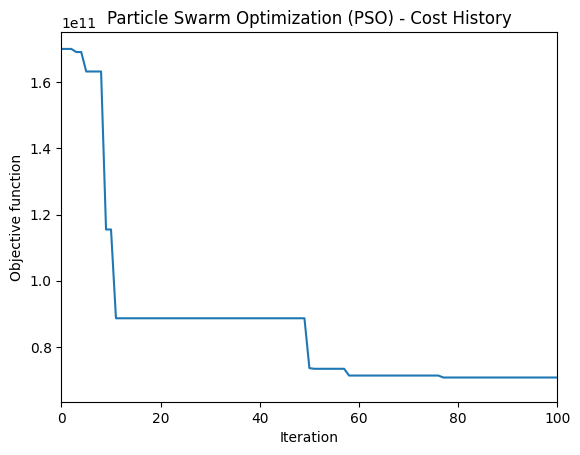

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 347246485110.82947


In [898]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

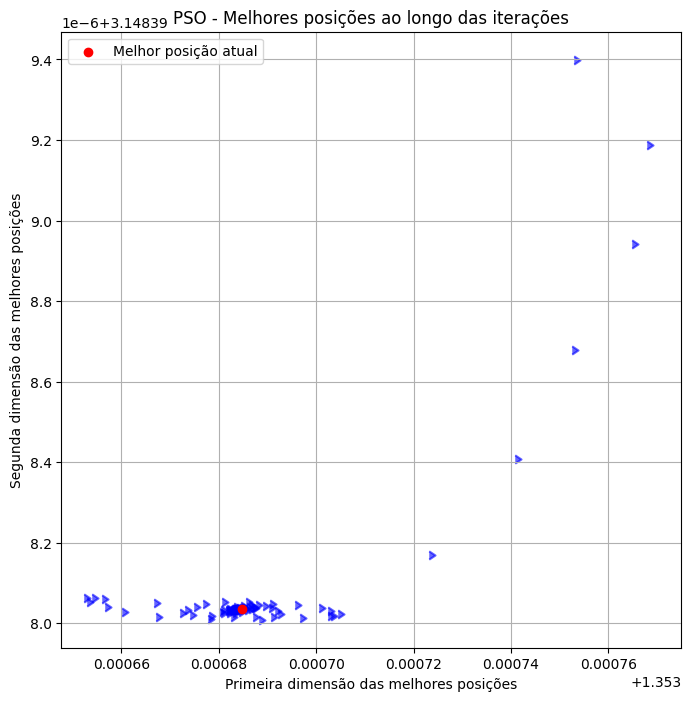

In [896]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()